In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import chi2_contingency
import warnings

warnings.filterwarnings('ignore')

In [53]:
data=pd.read_csv("online_shoppers_intention.csv")

In [54]:
data.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [55]:
data.shape


(12330, 18)

In [56]:
print(data.duplicated().sum())


125


In [57]:
data=data.drop_duplicates()

In [58]:
data.shape

(12205, 18)

In [59]:
numerical_columns=['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_columns=['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend','Revenue']

In [60]:
data['Revenue'].value_counts()

Revenue
False    10297
True      1908
Name: count, dtype: int64

In [61]:
data['VisitorType'].value_counts()

VisitorType
Returning_Visitor    10431
New_Visitor           1693
Other                   81
Name: count, dtype: int64

In [62]:
data['Weekend'].value_counts()

Weekend
False    9346
True     2859
Name: count, dtype: int64

In [63]:
# IQR function 
def IQR(x):
    x = x.astype(np.float32)
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    bb = q1 - 1.5*(q3 - q1)
    ba = q3 + 1.5*(q3 - q1)
    outlier_indices = list(x.index[(x < bb) | (x > ba)])
    outlier_values = list(x[outlier_indices])
    return len(outlier_indices)

In [64]:
total_outliers=0
for i in numerical_columns:
    print(f'Number of IQR outliers {i}: {IQR(data[i])}')

Number of IQR outliers Administrative: 404
Number of IQR outliers Administrative_Duration: 1149
Number of IQR outliers Informational: 2631
Number of IQR outliers Informational_Duration: 2405
Number of IQR outliers ProductRelated: 1007
Number of IQR outliers ProductRelated_Duration: 951
Number of IQR outliers BounceRates: 1428
Number of IQR outliers ExitRates: 1325
Number of IQR outliers PageValues: 2730
Number of IQR outliers SpecialDay: 1249


In [65]:
total_outliers = 0
total_data_points = 0

for i in numerical_columns:
    outliers = IQR(data[i])
    total_outliers += outliers
    total_data_points += len(data[i])

total_outlier_percentage = (total_outliers / total_data_points) * 100

print(f'Total outlier percentage: {total_outlier_percentage:.2f}%')

Total outlier percentage: 12.52%


In [66]:
# class oneHot(BaseEstimator, TransformerMixin):
#     def __init__(self, columns=None):
#         self.columns = columns
#         self.encoder = OneHotEncoder(sparse=False, drop='first')

#     def fit(self, X, y=None):
#         self.encoder.fit(X[self.columns])
#         return self

#     def transform(self, X, y=None):
#         onehot_encoded = self.encoder.transform(X[self.columns])
#         feature_names = self.encoder.get_feature_names_out()
#         result_df = pd.DataFrame(onehot_encoded, columns=feature_names, index=X.index)
#         return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [67]:
class StdScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        if (self.columns is None):
            self.columns = [col for col in X.columns if X[col].dtype in [np.float64, np.float32, np.int64, np.int32]]
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        scaled_data = self.scaler.transform(X[self.columns])
        result_df = pd.DataFrame(scaled_data, columns=self.columns, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [68]:
class AddNewVariables(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['Administrative_Duration_Page'] = X['Administrative_Duration']/data['Administrative']
        X['Informational_Duration_Page'] = X['Informational_Duration']/data['Informational']
        X['ProductRelated_Duration_Page'] = X['ProductRelated_Duration']/data['ProductRelated']
        
        # division by zero becomes zero
        X['Administrative_Duration_Page'] = X['Administrative_Duration_Page'].fillna(0)
        X['Informational_Duration_Page'] = X['Informational_Duration_Page'].fillna(0)
        X['ProductRelated_Duration_Page'] = X['ProductRelated_Duration_Page'].fillna(0)
     
        return X


In [69]:
class DropVariables(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(columns=self.columns_to_drop)

In [70]:
X = data.drop(['Revenue'], axis = 1)
y = data['Revenue']

In [71]:
y

0        False
1        False
2        False
3        False
4        False
         ...  
12325    False
12326    False
12327    False
12328    False
12329    False
Name: Revenue, Length: 12205, dtype: bool

In [72]:
X.shape

(12205, 17)

In [73]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [74]:
# label_encoder = LabelEncoder()
# data['Revenue']=label_encoder.fit_transform(data['Revenue'])
# x_train['Weekend']=label_encoder.fit_transform(data['Weekend'])
                                        

In [75]:
# onehot = pd.get_dummies(data['VisitorType'])
# data = data.join(onehot)

# data = data.drop(['VisitorType'], axis = 1)

In [76]:
y_train=LabelEncoder().fit_transform(y_train)
y_test=LabelEncoder().fit_transform(y_test)

In [77]:
pipe = Pipeline([
    ('add_new_vars', AddNewVariables()),
    ('drop_old_vars', DropVariables(columns_to_drop=['Administrative', 'Informational', 'ProductRelated', 'Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration'])),  
    #('oneHot', oneHot(columns=["VisitorType"])),
    ('scaler', StdScaler())
])

In [78]:
pipe1 = clone(pipe)

In [79]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [80]:
#true-1 false-0

X_train['Weekend'] = LabelEncoder().fit_transform(X_train['Weekend'])
     

# label encoding for Month
mapping_month = {'Jan' : 1, 'Feb' : 2,
                 'Mar' : 3, 'Apr' : 4,
                 'May' : 5, 'June' : 6,
                 'Jul' : 7, 'Aug' : 8,
                 'Sep' : 9, 'Oct' : 10,
                 'Nov' : 11, 'Dec' : 12}

X_train['Month'] = X_train['Month'].map(mapping_month)

X_test['Weekend'] = LabelEncoder().fit_transform(X_test['Weekend'])
     

# label encoding for Month
mapping_month = {'Jan' : 1, 'Feb' : 2,
                 'Mar' : 3, 'Apr' : 4,
                 'May' : 5, 'June' : 6,
                 'Jul' : 7, 'Aug' : 8,
                 'Sep' : 9, 'Oct' : 10,
                 'Nov' : 11, 'Dec' : 12}

X_test['Month'] = X_test['Month'].map(mapping_month)

In [81]:
one_hot_encoded_data =pd.get_dummies(X_train['VisitorType'],prefix="VType")
X_train = X_train.join(one_hot_encoded_data)
X_train = X_train.drop(['VisitorType'], axis = 1)

In [82]:
X_train


,Month,Weekend,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Administrative_Duration_Page,Informational_Duration_Page,ProductRelated_Duration_Page,VType_New_Visitor,VType_Other,VType_Returning_Visitor
6484,8,1,-0.450146,-0.668028,-0.316039,-0.305268,-0.140982,0.970759,2.020878,0.488078,1.328256,-0.226997,-0.234116,True,False,False
114,2,0,-0.163339,-0.126884,-0.316039,0.707117,-1.247973,-0.801796,-0.891393,-0.261724,-0.441439,1.194434,-0.066468,False,False,True
5405,5,0,1.865227,1.964628,-0.316039,2.731888,0.966009,-0.210944,1.188800,2.237618,-0.441439,-0.226997,-0.541185,False,False,True
4781,5,0,-0.450146,-0.472165,-0.316039,-0.305268,-0.140982,-0.210944,-0.059316,-0.761593,0.033275,-0.226997,-0.465149,False,False,True
2953,5,0,0.605207,0.490281,-0.316039,1.719503,0.966009,-0.210944,-0.891393,-0.261724,-0.441439,-0.226997,0.127402,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12086,11,0,0.290773,0.549239,-0.316039,-0.305268,-0.140982,-0.210944,1.604839,-0.261724,-0.441439,-0.226997,-0.618041,False,False,True
5272,5,1,-0.450146,-0.823990,-0.316039,-0.305268,-0.140982,-0.210944,-0.891393,-0.511659,-0.157559,0.063403,-0.206319,True,False,False
5475,10,0,-0.029624,0.041359,-0.048306,-0.305268,-0.140982,-0.210944,1.604839,-0.761593,0.411271,1.464863,-0.180371,False,False,True
874,3,1,-0.450146,-0.737775,-0.316039,-0.305268,0.966009,-0.210944,0.356723,-0.511659,0.019196,-0.226997,0.006178,False,False,True


In [83]:
X_train.shape

(8543, 16)

In [84]:
# y_train.value_counts()

In [85]:
smt=SMOTE()
X_train_smote,y_train_smote=smt.fit_resample(X_train,y_train)

In [86]:
print('AFTER oversampling (smote)')
print(pd.Series(y_train_smote).value_counts())

AFTER oversampling (smote)
0    7181
1    7181
Name: count, dtype: int64


# EDA

In [87]:
X_train.columns

Index(['Month', 'Weekend', 'BounceRates', 'ExitRates', 'PageValues',
       'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType',
       'Administrative_Duration_Page', 'Informational_Duration_Page',
       'ProductRelated_Duration_Page', 'VType_New_Visitor', 'VType_Other',
       'VType_Returning_Visitor'],
      dtype='object')

In [88]:
numerical_columns=['Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_columns=['Month','OperatingSystems','Browser','Region','TrafficType','VType_New_Visitor','VType_Other','VType_Returning_Visitor','Weekend']

Text(0.5, 1.0, 'Correlation Heatmap')

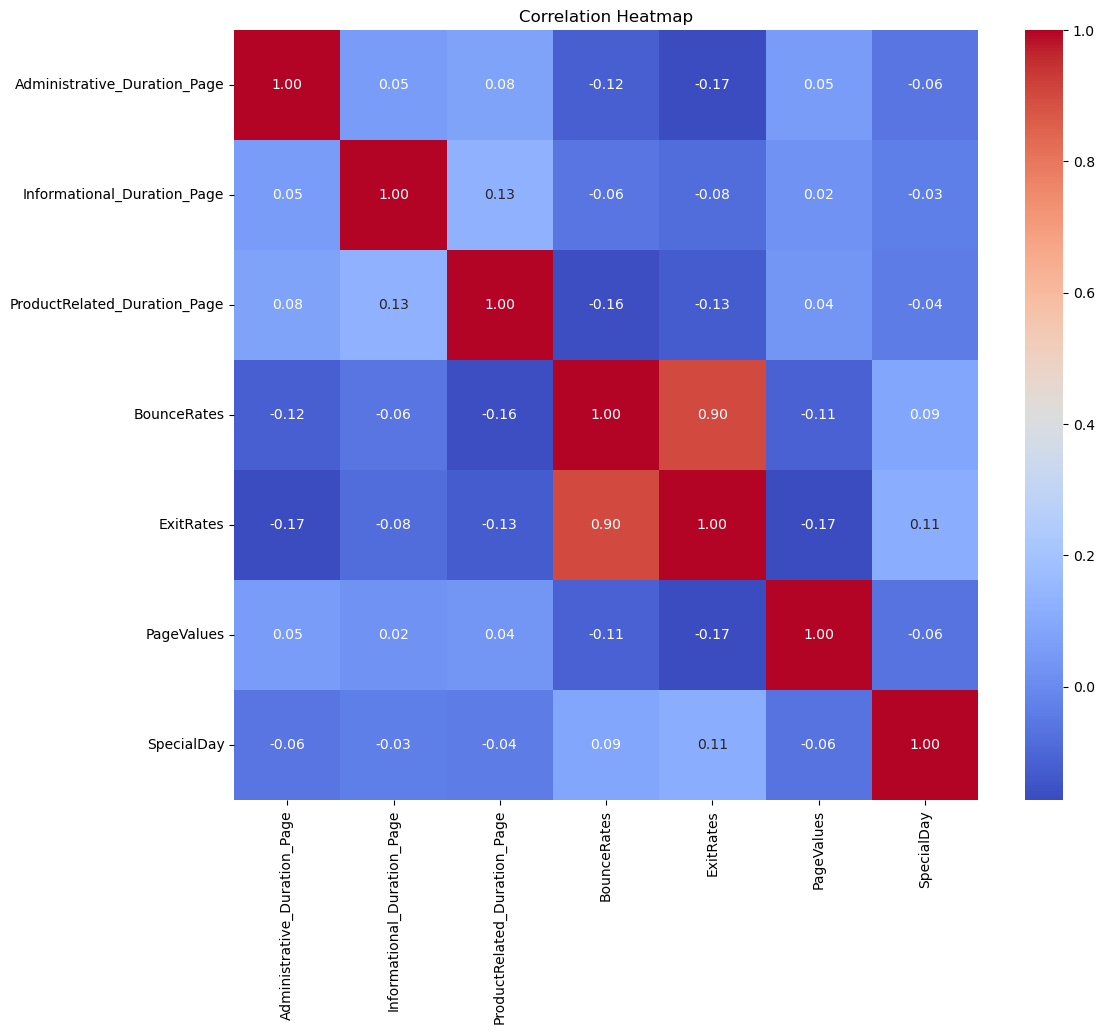

In [89]:
plt.figure(figsize=(12 , 10))
sns.heatmap(X_train[numerical_columns].corr(), cmap = 'coolwarm', annot = True, fmt = '.2f')
plt.title('Correlation Heatmap')

In [90]:
def ChiSquareContingency(data, y_train):
    p_value = chi2_contingency(pd.crosstab(data, y_train))[1]
    print(f'p-value: {p_value}')
    if p_value > 0.05:
        print(f'Accept H0, feature {data.name} is independent with Revenue')
    else:
        print(f'Reject H0, feature {data.name} is dependent with Revenue')

# Assuming you are iterating over categorical columns
for column in categorical_columns:
    ChiSquareContingency(X_train[column], y_train)
    print('')

p-value: 1.6351464585069558e-52
Reject H0, feature Month is dependent with Revenue

p-value: 1.0908594134349057e-08
Reject H0, feature OperatingSystems is dependent with Revenue

p-value: 0.007700184985415064
Reject H0, feature Browser is dependent with Revenue

p-value: 0.7276408547218776
Accept H0, feature Region is independent with Revenue

p-value: 1.7604246936686518e-42
Reject H0, feature TrafficType is dependent with Revenue

p-value: 2.3212741382161994e-21
Reject H0, feature VType_New_Visitor is dependent with Revenue

p-value: 0.9733241469555696
Accept H0, feature VType_Other is independent with Revenue

p-value: 8.81727274938809e-21
Reject H0, feature VType_Returning_Visitor is dependent with Revenue

p-value: 0.05252649771069415
Accept H0, feature Weekend is independent with Revenue



<Axes: ylabel='SpecialDay'>

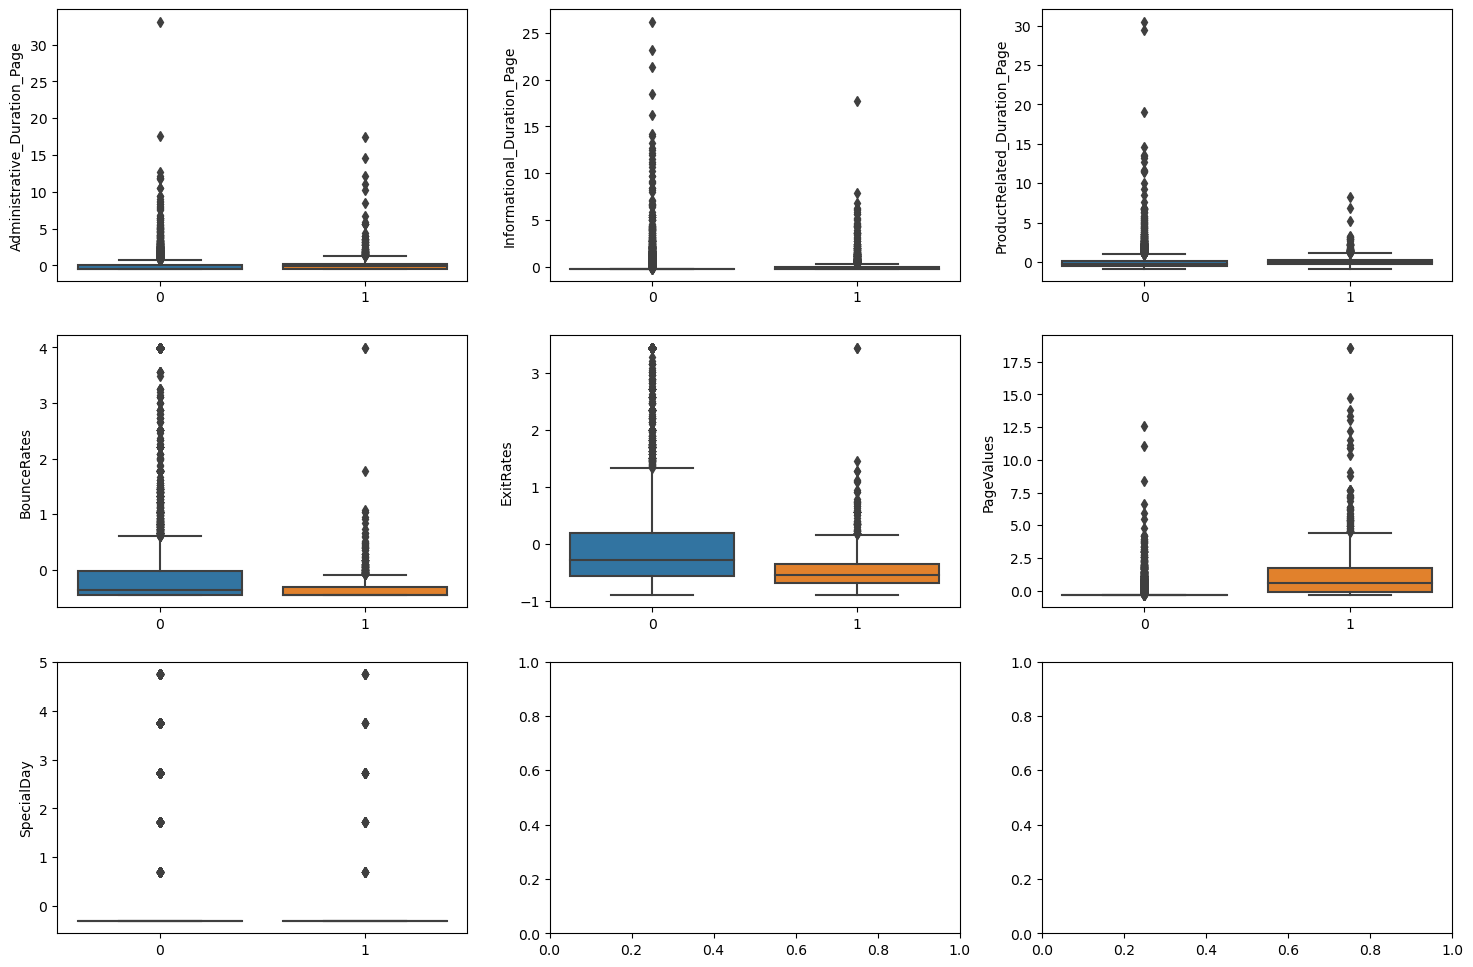

In [105]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))


sns.boxplot(ax=axes[0, 0], x=y_train, y=X_train['Administrative_Duration_Page'])
sns.boxplot(ax=axes[0, 1], x=y_train, y=X_train['Informational_Duration_Page'])
sns.boxplot(ax=axes[0, 2], x=y_train, y=X_train['ProductRelated_Duration_Page'])
sns.boxplot(ax=axes[1, 0], x=y_train, y=X_train['BounceRates'])
sns.boxplot(ax=axes[1, 1], x=y_train, y=X_train['ExitRates'])
sns.boxplot(ax=axes[1, 2], x=y_train, y=X_train['PageValues'])
sns.boxplot(ax=axes[2, 0], x=y_train, y=X_train['SpecialDay'])



# clustering


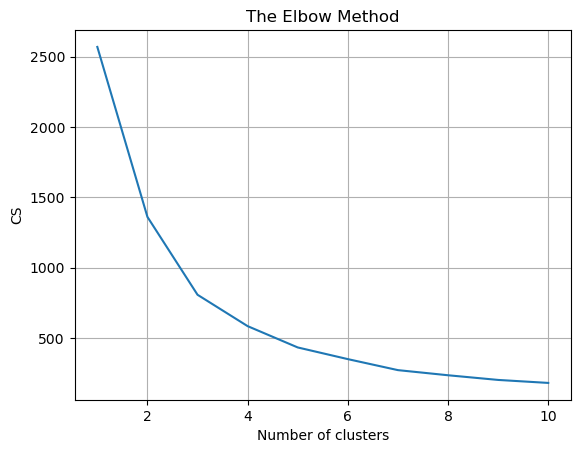

In [51]:
from sklearn.cluster import KMeans
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X_train)
    labels=kmeans.labels_
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.grid()
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [101]:
km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(X_train)
y_means

array([2, 1, 0, ..., 2, 1, 2])

[5 6 5 12 8 3 11 5 3 3 3 12 3 3 11 8 5 5 5 5 8 3 5 11 7 7 5 5 3 3 3 3 11
 11 12 5 11 5 12 5 5 5 5 5 7 5 5 5 7 5 5 5 12 9 5 8 5 3 12 12 11 5 8 5 8 3
 12 12 11 3 5 12 6 11 12 2 11 2 5 3 11 6 5 5 6 5 5 5 11 2 11 2 12 3 11 11
 12 5 5 5 5 5 6 7 8 2 5 2 11 5 11 5 3 12 5 11 11 9 5 5 12 5 5 11 5 3 5 5 5
 5 3 3 5 7 11 5 2 7 7 12 11 5 5 12 5 7 11 8 12 7 8 6 11 11 11 6 2 5 5 8 11
 5 5 3 7 12 12 11 12 7 11 6 5 11 5 5 5 5 7 8 3 2 5 11 5 6 9 12 12 5 11 8 5
 7 11 3 5 3 12 6 3 5 5 3 5 11 5 5 5 11 12 11 12 10 11 12 11 5 5 11 5 11 5
 5 5 12 11 3 6 6 9 12 5 12 7 5 5 11 5 6 11 7 5 12 5 11 8 7 2 12 11 11 5 5
 3 11 5 12 2 11 5 3 5 5 8 5 12 5 5 5 12 5 5 2 2 12 3 3 5 3 3 6 3 12 3 5 5
 5 11 11 5 5 5 11 3 5 5 5 10 6 5 5 3 11 2 5 5 3 3 5 5 8 3 3 2 5 5 5 12 11
 11 5 5 6 12 12 5 5 3 11 10 2 5 11 11 5 5 8 8 11 11 5 3 11 11 5 5 5 5 5 9
 2 11 2 8 5 5 5 3 11 5 7 5 11 11 11 7 11 11 2 5 3 5 5 5 11 8 12 7 3 5 5 12
 11 5 3 11 11 12 7 5 10 5 2 5 3 7 5 12 12 3 5 12 11 5 5 11 5 5 5 5 10 11 3
 11 7 12 5 11 12 3 5 3 5 3 3 5 5 

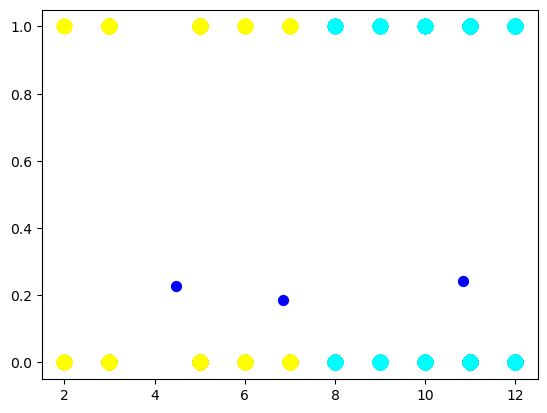

In [104]:
x=X_train.values
plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s = 100, c = 'pink', label = 'Un-interested Customers')
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s = 100, c = 'yellow', label = 'General Customers')
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1], s = 100, c = 'cyan', label = 'Target Customers')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centeroid')
